### Imports

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

### Configurations

In [5]:
M           = 8                 # Number of clients
A           = 10                # Local epochs
G           = 100               # Global rounds
bs          = 64                # Batch size
lr          = 0.01              # Learning rate
clip_C      = 1.0               # Clipping norm
delta       = 1e-5              # DP parameter delta
eps_list    = [1, 2, 5, 10]     # Privacy budgets ε
T_sc        = 10.0              # Sensing interval per round (seconds)
c_s         = 0.1               # Sensing sampling period (seconds)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model Defination

In [6]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28,32)
        self.fc2 = nn.Linear(32,10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

### Growing Dataset With Sensing Simulation

In [7]:
class GrowingDataset(Dataset):
    """
    Maintains an evolving dataset: initial real samples + synthetic sensed samples.
    """
    def __init__(self, base_dataset, initial_indices=None):
        self.data = []
        self.targets = []
        # Load initial subset
        if initial_indices is None:
            indices = range(len(base_dataset))
        else:
            indices = initial_indices
        for idx in indices:
            x, y = base_dataset[idx]
            self.data.append(x)
            self.targets.append(y)

    def maybe_add_sensed_samples(self, a_mt):
        # number of new samples this round
        n_new = int((a_mt * T_sc) // c_s)
        for _ in range(n_new):
            # synthetic 28x28 Gaussian feature + random label
            x_new = torch.randn(1,28,28)
            y_new = torch.randint(0,10,(1,)).item()
            self.data.append(x_new)
            self.targets.append(y_new)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

### IID Initialization of Clients' GrowingDataset

In [8]:
def init_iid_growing_datasets(base_dataset, M):

    """
    Initialize M datasets with IID samples from the base dataset.
    Each client gets an equal share of the initial dataset.
    """

    # shuffle and split indices
    idx = torch.randperm(len(base_dataset)).tolist()
    split_size = len(base_dataset) // M
    client_dsets = []
    for i in range(M):
        part = idx[i*split_size:(i+1)*split_size]
        gd = GrowingDataset(base_dataset, initial_indices=part)
        client_dsets.append(gd)
    return client_dsets

### DP Clip & Noise 

In [9]:
def dp_clip_and_noise(client_model, global_model, epsilon, delta, clip_C, G, D_tau_min):
    sensitivity = (2 * clip_C) / D_tau_min
    sigma = (sensitivity * np.sqrt(2 * G * np.log(1.25 / delta))) / epsilon

    g_state = global_model.state_dict()
    c_state = client_model.state_dict()
    new_state = {}

    for k in g_state:
        delta_w = c_state[k].to(device) - g_state[k].to(device)
        norm = torch.norm(delta_w)

        if norm > clip_C:
            delta_w = delta_w * (clip_C / norm)

        noise = torch.randn_like(delta_w) * sigma
        new_state[k] = g_state[k].to(device) + delta_w + noise

    return new_state

### Server Aggregation

In [10]:
def server_aggregate(states):
    agg = {}
    for k in states[0]:
        agg[k] = sum([st[k] for st in states]) / len(states)
    return agg

### TRAIN & EVAL LOOPS

In [11]:
def local_train(model, loader, global_state):
    model.load_state_dict(global_state)
    opt = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for _ in range(A):
        for x,y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss_fn(logits, y).backward()
            opt.step()

def evaluate(model, loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x,y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            total_loss += loss_fn(logits, y).item()
            _,pred = logits.max(1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    return total_loss/total, correct/total

### Main Experiment with Sensing

In [12]:
# Load MNIST
transform = transforms.ToTensor()
train_ds  = datasets.MNIST('.',train=True,download=True,transform=transform)
test_ds   = datasets.MNIST('.',train=False,download=True,transform=transform)
test_loader = DataLoader(test_ds,batch_size=bs, shuffle=False)

# Initialize client datasets
client_datasets = init_iid_growing_datasets(train_ds, M)

# To track growth per client
data_growth = {m: [] for m in range(M)}

results = {}
for eps in eps_list:
    print(f"\n=== Running ε = {eps} ===")
    global_model = SimpleMLP().to(device)
    global_state = global_model.state_dict()

    loss_hist, acc_hist = [], []

    # Reset datasets for each epsilon
    client_datasets = init_iid_growing_datasets(train_ds, M)
    data_growth = {m: [] for m in range(M)}

    for rnd in range(1, G+1):
        dp_states = []
        # each client senses & trains
        for m, dset in enumerate(client_datasets):
            # sensing step
            a_mt = 0.5  # fixed schedule
            dset.maybe_add_sensed_samples(a_mt)

            # update growth tracker
            data_growth[m].append(len(dset))

            # local training loader
            loader = DataLoader(dset, batch_size=bs, shuffle=True)
            local_model = SimpleMLP().to(device)
            local_train(local_model, loader, global_state)

            # DP update
            D_tau_min = min(len(ds) for ds in client_datasets)
            dp_state = dp_clip_and_noise(local_model, global_model, eps, delta, clip_C, G, D_tau_min)
            dp_states.append(dp_state)

        # aggregate
        agg_state = server_aggregate(dp_states)
        global_state = agg_state
        global_model.load_state_dict(global_state)

        # evaluation
        loss, acc = evaluate(global_model, test_loader)
        loss_hist.append(loss)
        acc_hist.append(acc)

        if rnd % 20 == 0:
            print(f" Round {rnd:3d}  Loss {loss:.4f}  Acc {acc:.3f}")

    results[eps] = (loss_hist, acc_hist)

100.0%
100.0%
100.0%
100.0%



=== Running ε = 1 ===
 Round  20  Loss 0.2230  Acc 0.936
 Round  40  Loss 0.1796  Acc 0.948
 Round  60  Loss 0.1653  Acc 0.954
 Round  80  Loss 0.1600  Acc 0.953
 Round 100  Loss 0.1577  Acc 0.955

=== Running ε = 2 ===
 Round  20  Loss 0.2136  Acc 0.938
 Round  40  Loss 0.1767  Acc 0.952
 Round  60  Loss 0.1645  Acc 0.954
 Round  80  Loss 0.1592  Acc 0.954
 Round 100  Loss 0.1591  Acc 0.955

=== Running ε = 5 ===
 Round  20  Loss 0.2238  Acc 0.939
 Round  40  Loss 0.1799  Acc 0.949
 Round  60  Loss 0.1636  Acc 0.953
 Round  80  Loss 0.1595  Acc 0.952
 Round 100  Loss 0.1604  Acc 0.953

=== Running ε = 10 ===
 Round  20  Loss 0.2185  Acc 0.938
 Round  40  Loss 0.1692  Acc 0.954
 Round  60  Loss 0.1538  Acc 0.956
 Round  80  Loss 0.1493  Acc 0.958
 Round 100  Loss 0.1501  Acc 0.956


### Plot FL Metrics

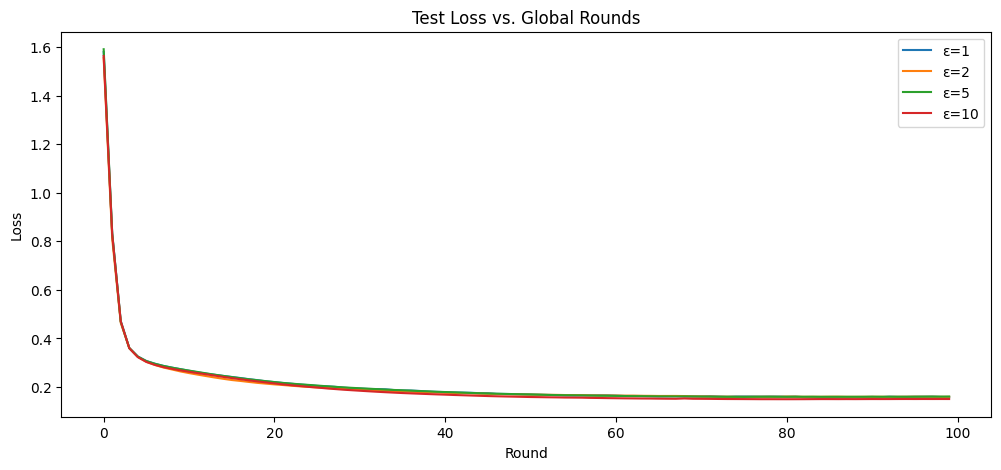

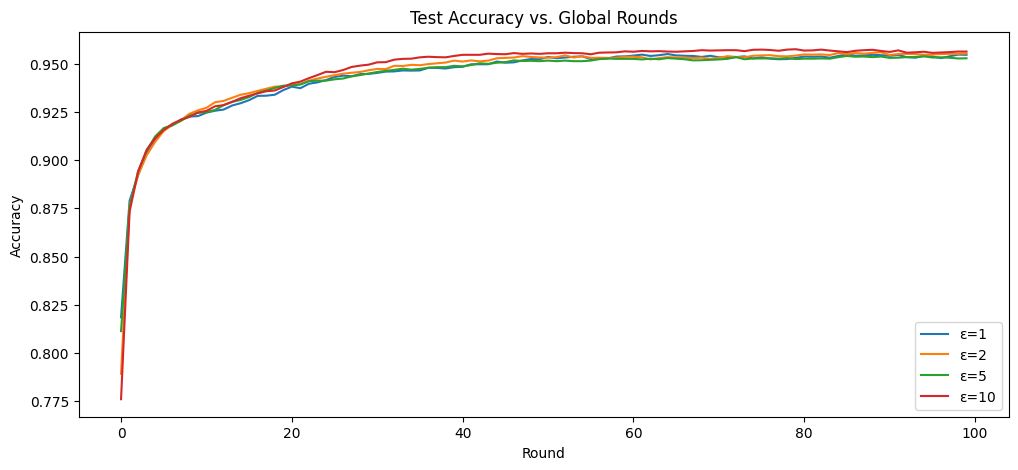

In [13]:
plt.figure(figsize=(12,5))
for eps,(l,a) in results.items():
    plt.plot(l, label=f"ε={eps}")
plt.title("Test Loss vs. Global Rounds")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
for eps,(l,a) in results.items():
    plt.plot(a, label=f"ε={eps}")
plt.title("Test Accuracy vs. Global Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Plot dataset growth per client (for a single epsilon or averaged)


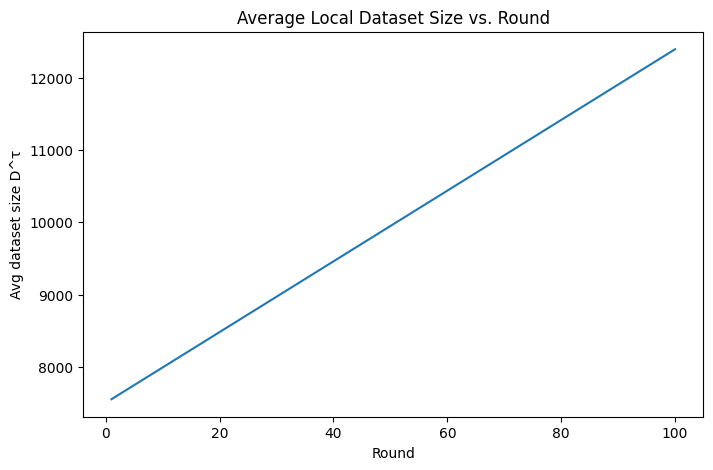

In [14]:
avg_growth = np.mean([data_growth[m] for m in data_growth], axis=0)

plt.figure(figsize=(8,5))
plt.plot(range(1, G+1), avg_growth)
plt.title("Average Local Dataset Size vs. Round")
plt.xlabel("Round")
plt.ylabel("Avg dataset size D^τ")
plt.show()